In [36]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import scipy as sp
from autograd import grad, jacobian
import pennylane as qml

from pennylane import numpy as pnp

# ==============================
# User defined 
# ==============================

In [37]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=3)

# Define Hamiltonian for quantum computations
# H = qml.Hamiltonian(coeffs=[-0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1)])

# H = qml.Hamiltonian(coeffs=[-0.5], observables=[qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2)])
# H_1 = qml.Hamiltonian(coeffs=[-0.5, -0.5, -0.5], observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)])

H = qml.Hamiltonian(
    coeffs=[-0.5, -1], 
    observables=[
        qml.PauliZ(0) @ qml.PauliZ(1) @ qml.Identity(2), 
        qml.Identity(0) @ qml.PauliZ(1) @ qml.PauliZ(2)
    ]
)

H_1 = qml.Hamiltonian(
    coeffs=[-0.5, -0.5, -0.5], 
    observables=[qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2)]
)

In [38]:
# Global Parameters
Tau_global = 0
Gamma_ps_global = 0
Paras_global = pnp.zeros(6)
Phi_global = pnp.array([0], requires_grad = True)

def Dephase_factor(tau):
    """
    Calculates the dephasing factor as a function of the time parameter tau.

    Args:
        tau (float): A time parameter influencing the dephasing.

    Returns:
        float: The calculated dephasing factor.
    """
    return 1 - pnp.exp(-2 * tau)

In [39]:
@qml.qnode(dev)
def circuit(phi):
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z1 = Paras_global[1]
    phi_z2 = Paras_global[2]
    phi_z3 = Paras_global[3]
    tau_1 = Paras_global[4]
    tau_2 = Paras_global[5]
    
    gamma_dephase = Dephase_factor(Tau_global)
    
    # Stage_1: RY for pi/2
    qml.RY(np.pi/2, wires=0)
    qml.RY(np.pi/2, wires=1)
    qml.RY(np.pi/2, wires=2)
    
    # Stage_2: Entangler    
    qml.ApproxTimeEvolution(H, tau_1, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1)    
    qml.PhaseDamping(gamma_dephase, wires = 2)    
    
    qml.RX(theta_x, wires = 0)    
    qml.RX(theta_x, wires = 1)    
    qml.RX(theta_x, wires = 2)    

    qml.RY(-np.pi/2, wires = 0)    
    qml.RY(-np.pi/2, wires = 1)   
    qml.RY(-np.pi/2, wires = 2)   

    qml.ApproxTimeEvolution(H, tau_2, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 
    
    qml.RY(np.pi/2, wires = 0)    
    qml.RY(np.pi/2, wires = 1) 
    qml.RY(np.pi/2, wires = 2) 
    
    # Stage_3: Accumulator
    qml.ApproxTimeEvolution(H_1, phi, 1)
    
    qml.PhaseDamping(gamma_dephase, wires = 0)
    qml.PhaseDamping(gamma_dephase, wires = 1) 
    qml.PhaseDamping(gamma_dephase, wires = 2) 

    qml.RZ(phi_z1, wires=0)
    qml.RZ(phi_z2, wires=1)
    qml.RZ(phi_z3, wires=2)
    
    qml.RX(np.pi/(2), wires=0)
    qml.RX(np.pi/(2), wires=1)
    qml.RX(np.pi/(2), wires=2)
    
    # return qml.state()
    return qml.density_matrix(wires = [0, 1, 2])

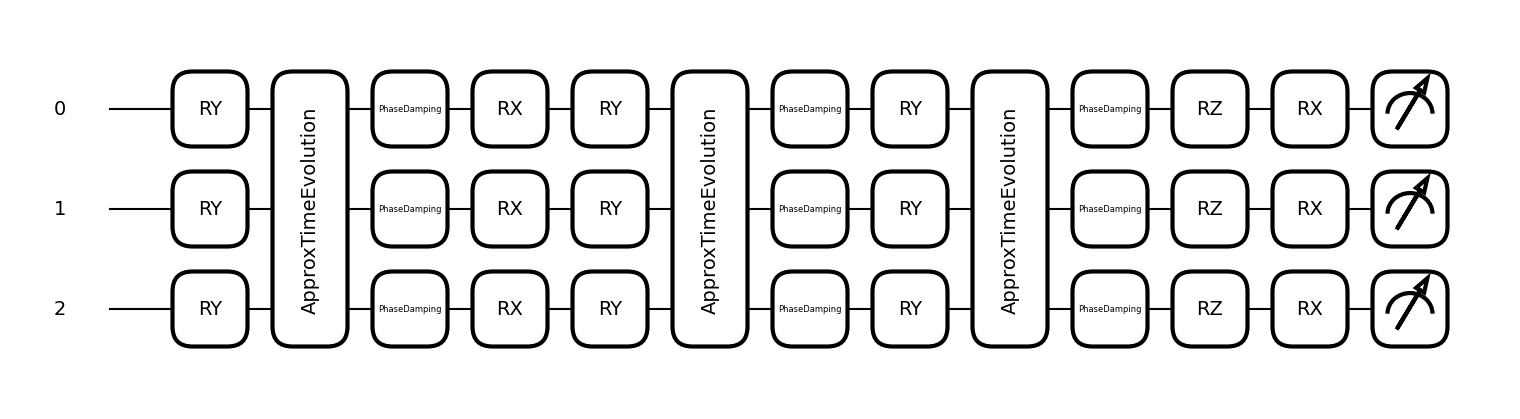

In [40]:
fig, ax = qml.draw_mpl(circuit)(np.pi)

In [41]:
@qml.qnode(dev)
def Post_selection(phi):

    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = pnp.tensor([
        [pnp.sqrt(1 - Gamma_ps_global), 0], 
        [0, 1]
    ], dtype=pnp.complex128)
    
    Numerator = pnp.kron(K, pnp.kron(K, K)) @ get_density_matrix @ pnp.kron(K, pnp.kron(K, K)).conj().T
    Denominator = pnp.trace(Numerator)
    
    rho_ps = Numerator / Denominator
    
    qml.QubitDensityMatrix(rho_ps, wires = [0, 1, 2])
    
    return qml.density_matrix(wires = [0, 1, 2])  

In [42]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Sets global parameters for dephasing time and gamma post-selection.

    Args:
        desired_tau_dephase (float): The desired dephasing time.
        desired_gamma_post_selection (float): The gamma value for post-selection.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = desired_tau_dephase
    Gamma_ps_global = desired_gamma_post_selection

In [43]:
def cost_function(paras):
    """
    Defines the cost function for optimization, which is the negative of the 
    Classical Fisher Information (CFI).

    Args:
        paras (array): Parameters to optimize.

    Returns:
        float: The negative value of the CFI for the given parameters.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)
    
    return -CFI

In [44]:
class INDEX_3(Enum):
    THETA_X = 0
    
    PHI_Z1 = 1
    PHI_Z2 = 2
    PHI_Z3 = 3
    
    TAU_1 = 4
    TAU_2 = 5
    
def get_constraints(phi_current):
    N =2*np.pi * int(phi_current / (2*np.pi))
    default_0 = [
                (-1e-3, 1e-3),              # THETA_X
                (-float('inf'), float('inf')),       # PHI_Z1
                (-float('inf'), float('inf')),  # PHI_Z2
                (-float('inf'), float('inf')),       # PHI_Z3
                (1.8469596e-01, 1.8469596e-01),   # tau_1
                (np.pi/2, np.pi/2)          # tau_2
            ]
    # temp_0 = default_0
    
    # if 0.51 + N <= phi_current <= 0.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.07669747, 2.38469112) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (2.09160427, 2.37050667)
    #     return temp_0
        
    # elif 1.21 + N <= phi_current <= 1.81 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (2.77673923, 3.38486445) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-3.49168366, -2.91311528)
    #     return temp_0
    
    # elif 2.41 + N <= phi_current <= 3.01 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (3.97677551, 4.58495462) 
    #     temp_0[INDEX_3.PHI_Z2.value] = (-2.29178612, -1.71334716)
    #     return temp_0
    
    # elif 3.01 + N <= phi_current <= 3.61 + N:
    #     temp_0[INDEX_3.PHI_Z1.value] = temp_0[INDEX_3.PHI_Z3.value] = (-np.pi, 4.68483876)
    #     temp_0[INDEX_3.PHI_Z2.value] = (-1.71334716, -1.11319924)
    #     return temp_0

    # else: 
    return default_0


In [45]:
# ===================
tau_set = np.array([0])
gamma_ps_set = 0
set_circuit(tau_set, gamma_ps_set)
initial_parameters = np.zeros(6)
initial_parameters[:6] = np.pi/2

# initial_parameters[0] = 0

sweep_range = np.array([1e-2, np.pi*2, 1e-1])
Phi = np.arange(sweep_range[0], sweep_range[1], sweep_range[2])
Data = np.zeros((len(Phi), len(initial_parameters) + 2))
Data[:,0] = Phi
gradient = grad(cost_function)
hessian = jacobian(gradient)

for tau_idx, tau_current in enumerate(tau_set):
    set_circuit(tau_current, gamma_ps_set)
    for phi_idx, phi_current in enumerate(Phi):
        Phi_global = pnp.array([phi_current], requires_grad = True)

        opt_result = sp.optimize.minimize(
            fun = cost_function, 
            x0 = initial_parameters, 
            method = 'L-BFGS-B', 
            # bounds = get_constraints(phi_current),
            bounds = [
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf')),  # phi_z2
                (-float('inf'), float('inf'))  # phi_z2
            ], 

            jac = gradient,
            tol = 1e-12,
            options={
                'ftol': 1e-12, 
                'gtol': 1e-12
            }
        )
        # print(get_constraints(phi_current))
        formatted_x = [f"{x:.8f}" for x in opt_result.x]
        print("CFI =", f"{-opt_result.fun:.5f}", "Paras =", formatted_x)

        Data[phi_idx][1] = -opt_result.fun
        Data[phi_idx][2:] = opt_result.x

CFI = 7.59423 Paras = ['2.77697127', '1.58124882', '1.58124887', '1.58124883', '0.94764529', '0.73347877']
CFI = 7.59422 Paras = ['2.77774285', '1.68117244', '1.68117243', '1.68117241', '0.94764334', '0.73435209']
CFI = 7.59423 Paras = ['2.77757927', '1.78124239', '1.78124245', '1.78124237', '0.94759497', '0.73380383']
CFI = 5.00000 Paras = ['1.57077530', '1.63484276', '1.63563721', '1.57020716', '1.57079687', '0.78539853']
CFI = 5.00000 Paras = ['1.57081152', '1.65774157', '1.65819738', '1.56970768', '1.57079566', '0.78539773']
CFI = 7.59423 Paras = ['2.77727316', '2.08126412', '2.08126417', '2.08126416', '0.94761344', '0.73351399']
CFI = 7.59423 Paras = ['2.77698898', '2.18125927', '2.18125935', '-0.96033335', '0.94763667', '0.73348270']
CFI = 7.59423 Paras = ['2.77693763', '2.28034959', '2.28034958', '2.28034957', '0.94749130', '0.73347226']
CFI = 7.59423 Paras = ['2.77760809', '-0.76143287', '2.38015979', '2.38015978', '0.94772237', '0.73414421']
CFI = 7.59422 Paras = ['2.77788670'

In [46]:
Data

array([[ 1.00000000e-02,  7.59422757e+00,  2.77697127e+00,
         1.58124882e+00,  1.58124887e+00,  1.58124883e+00,
         9.47645287e-01,  7.33478774e-01],
       [ 1.10000000e-01,  7.59422473e+00,  2.77774285e+00,
         1.68117244e+00,  1.68117243e+00,  1.68117241e+00,
         9.47643336e-01,  7.34352086e-01],
       [ 2.10000000e-01,  7.59422659e+00,  2.77757927e+00,
         1.78124239e+00,  1.78124245e+00,  1.78124237e+00,
         9.47594975e-01,  7.33803825e-01],
       [ 3.10000000e-01,  5.00000000e+00,  1.57077530e+00,
         1.63484276e+00,  1.63563721e+00,  1.57020716e+00,
         1.57079687e+00,  7.85398533e-01],
       [ 4.10000000e-01,  5.00000000e+00,  1.57081152e+00,
         1.65774157e+00,  1.65819738e+00,  1.56970768e+00,
         1.57079566e+00,  7.85397735e-01],
       [ 5.10000000e-01,  7.59422718e+00,  2.77727316e+00,
         2.08126412e+00,  2.08126417e+00,  2.08126416e+00,
         9.47613440e-01,  7.33513991e-01],
       [ 6.10000000e-01,  7.594227

In [47]:
# np.savetxt("[0].csv", Data, delimiter=",")

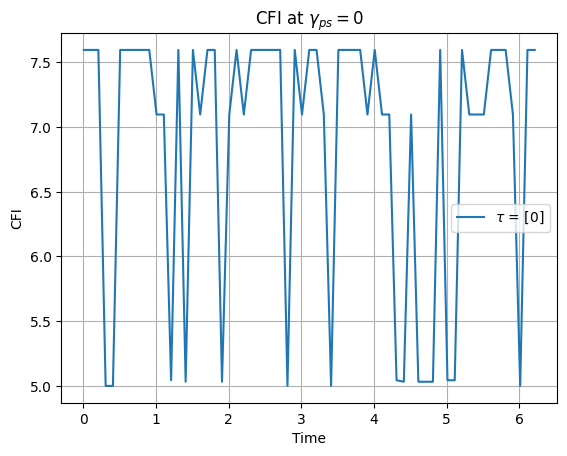

In [48]:
plt.plot(Data[:,0], Data[:,1], label = f'$\\tau$ = {tau_set}')
plt.title(f'CFI at $\gamma_{{ps}} = {gamma_ps_set}$')
plt.xlabel('Time')
plt.ylabel('CFI')
plt.grid()
plt.legend()
plt.show()

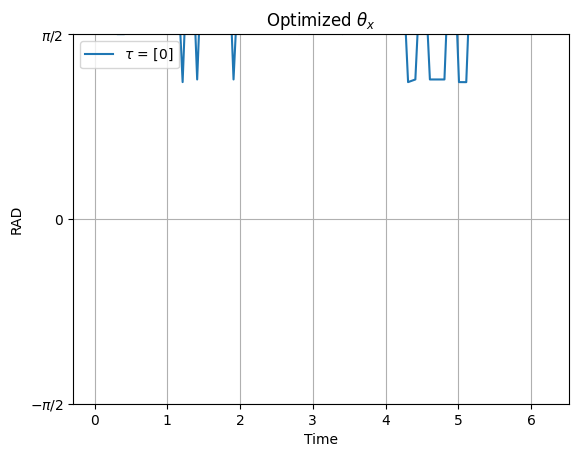

In [49]:
plt.plot(Data[:,0], Data[:,2], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-np.pi/2, np.pi/2)
plt.title(f'Optimized $\\theta_{{x}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

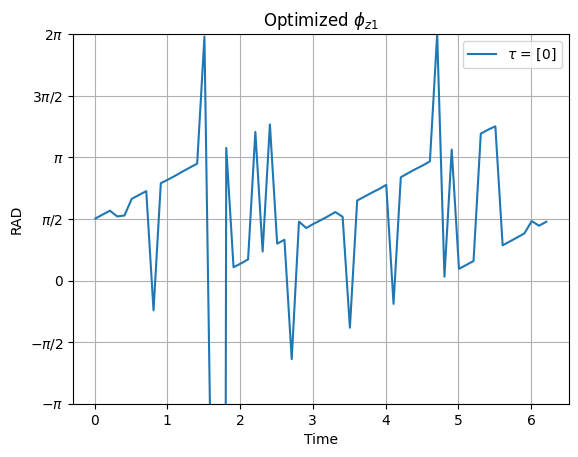

In [50]:
plt.plot(Data[:,0], Data[:,3], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z1}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [51]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z1:", f"{Data[idx, 3]:.8f}")

PHI: 0.01 phi_z1: 1.58124882
PHI: 0.11 phi_z1: 1.68117244
PHI: 0.21 phi_z1: 1.78124239
PHI: 0.31 phi_z1: 1.63484276
PHI: 0.41 phi_z1: 1.65774157
PHI: 0.51 phi_z1: 2.08126412
PHI: 0.61 phi_z1: 2.18125927
PHI: 0.71 phi_z1: 2.28034959
PHI: 0.81 phi_z1: -0.76143287
PHI: 0.91 phi_z1: 2.48128000
PHI: 1.01 phi_z1: 2.57420622
PHI: 1.11 phi_z1: 2.67418121
PHI: 1.21 phi_z1: 2.78030319
PHI: 1.31 phi_z1: 2.88125809
PHI: 1.41 phi_z1: 2.98085353
PHI: 1.51 phi_z1: 6.22285354
PHI: 1.61 phi_z1: -6.25189239
PHI: 1.71 phi_z1: -87.82493357
PHI: 1.81 phi_z1: 3.38124220
PHI: 1.91 phi_z1: 0.33914690
PHI: 2.01 phi_z1: 0.43325595
PHI: 2.11 phi_z1: 0.53834834
PHI: 2.21 phi_z1: 3.78864650
PHI: 2.31 phi_z1: 0.73866120
PHI: 2.41 phi_z1: 3.98170689
PHI: 2.51 phi_z1: 0.93965633
PHI: 2.61 phi_z1: 1.03876892
PHI: 2.71 phi_z1: -2.00286846
PHI: 2.81 phi_z1: 1.50175970
PHI: 2.91 phi_z1: 1.33871463
PHI: 3.01 phi_z1: 1.44574590
PHI: 3.11 phi_z1: 1.53982957
PHI: 3.21 phi_z1: 1.63966445
PHI: 3.31 phi_z1: 1.74583628
PHI: 3.41

In [52]:
get_constraints(1.51)

[(-0.001, 0.001),
 (-inf, inf),
 (-inf, inf),
 (-inf, inf),
 (0.18469596, 0.18469596),
 (1.5707963267948966, 1.5707963267948966)]

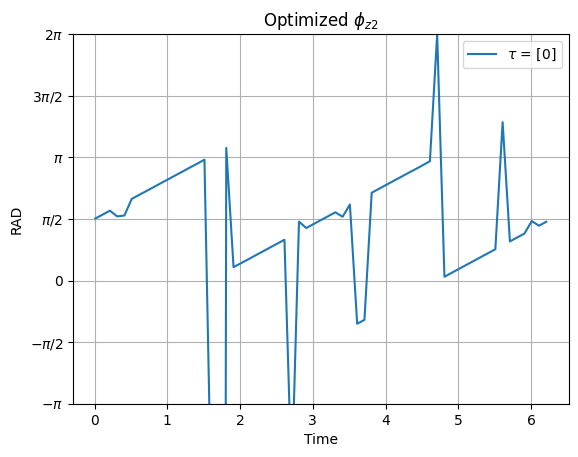

In [53]:
plt.plot(Data[:,0], Data[:,4], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z2}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [54]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z2:", f"{Data[idx, 4]:.8f}")

PHI: 0.01 phi_z2: 1.58124887
PHI: 0.11 phi_z2: 1.68117243
PHI: 0.21 phi_z2: 1.78124245
PHI: 0.31 phi_z2: 1.63563721
PHI: 0.41 phi_z2: 1.65819738
PHI: 0.51 phi_z2: 2.08126417
PHI: 0.61 phi_z2: 2.18125935
PHI: 0.71 phi_z2: 2.28034958
PHI: 0.81 phi_z2: 2.38015979
PHI: 0.91 phi_z2: 2.48127999
PHI: 1.01 phi_z2: 2.58078218
PHI: 1.11 phi_z2: 2.68078221
PHI: 1.21 phi_z2: 2.78030328
PHI: 1.31 phi_z2: 2.88125810
PHI: 1.41 phi_z2: 2.97878078
PHI: 1.51 phi_z2: 3.08126087
PHI: 1.61 phi_z2: -6.24399861
PHI: 1.71 phi_z2: -87.82493358
PHI: 1.81 phi_z2: 3.38124225
PHI: 1.91 phi_z2: 0.34120696
PHI: 2.01 phi_z2: 0.43919098
PHI: 2.11 phi_z2: 0.53834832
PHI: 2.21 phi_z2: 0.63922045
PHI: 2.31 phi_z2: 0.73866123
PHI: 2.41 phi_z2: 0.84011425
PHI: 2.51 phi_z2: 0.93965634
PHI: 2.61 phi_z2: 1.03876892
PHI: 2.71 phi_z2: -5.14446111
PHI: 2.81 phi_z2: 1.50074174
PHI: 2.91 phi_z2: 1.33871457
PHI: 3.01 phi_z2: 1.43921761
PHI: 3.11 phi_z2: 1.53982954
PHI: 3.21 phi_z2: 1.63966446
PHI: 3.31 phi_z2: 1.73921788
PHI: 3.41 

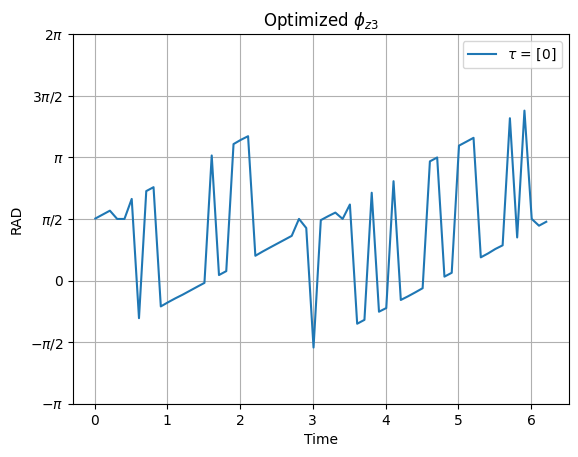

In [55]:
plt.plot(Data[:,0], Data[:,5], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(-2*np.pi/2, 4*np.pi/2)
plt.title(f'Optimized $\\phi_{{z3}}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [56]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "phi_z3:", f"{Data[idx, 5]:.8f}")

PHI: 0.01 phi_z3: 1.58124883
PHI: 0.11 phi_z3: 1.68117241
PHI: 0.21 phi_z3: 1.78124237
PHI: 0.31 phi_z3: 1.57020716
PHI: 0.41 phi_z3: 1.56970768
PHI: 0.51 phi_z3: 2.08126416
PHI: 0.61 phi_z3: -0.96033335
PHI: 0.71 phi_z3: 2.28034957
PHI: 0.81 phi_z3: 2.38015978
PHI: 0.91 phi_z3: -0.66031269
PHI: 1.01 phi_z3: -0.55406030
PHI: 1.11 phi_z3: -0.45403465
PHI: 1.21 phi_z3: -0.36128938
PHI: 1.31 phi_z3: -0.26033456
PHI: 1.41 phi_z3: -0.15926771
PHI: 1.51 phi_z3: -0.06033178
PHI: 1.61 phi_z3: 3.18888220
PHI: 1.71 phi_z3: 0.13966072
PHI: 1.81 phi_z3: 0.23964952
PHI: 1.91 phi_z3: 3.47927701
PHI: 2.01 phi_z3: 3.58687614
PHI: 2.11 phi_z3: 3.67994098
PHI: 2.21 phi_z3: 0.63118005
PHI: 2.31 phi_z3: 0.73866122
PHI: 2.41 phi_z3: 0.84011421
PHI: 2.51 phi_z3: 0.93965636
PHI: 2.61 phi_z3: 1.03876892
PHI: 2.71 phi_z3: 1.13872420
PHI: 2.81 phi_z3: 1.57146694
PHI: 2.91 phi_z3: 1.33871462
PHI: 3.01 phi_z3: -1.70907621
PHI: 3.11 phi_z3: 1.53982955
PHI: 3.21 phi_z3: 1.63966445
PHI: 3.31 phi_z3: 1.73242415
PHI: 

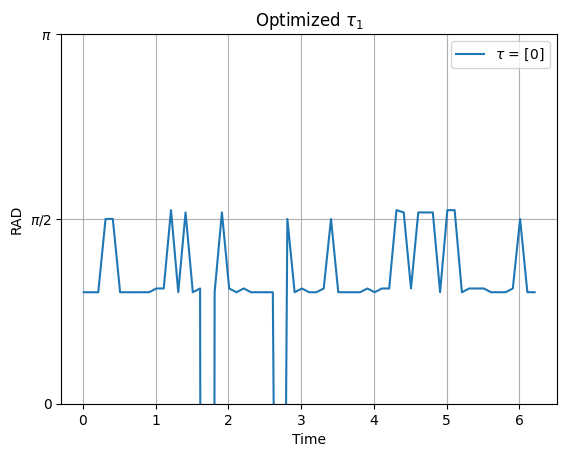

In [57]:
plt.plot(Data[:,0], Data[:,6], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{1}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()

In [58]:
Data[:,6]

array([  0.94764529,   0.94764334,   0.94759497,   1.57079687,
         1.57079566,   0.94761344,   0.94763667,   0.9474913 ,
         0.94772237,   0.94810455,   0.97946409,   0.97945917,
         1.64540277,   0.94756653,   1.62581249,   0.94760441,
         0.97950313, -36.75134053,   0.94764246,   1.62580214,
         0.97936387,   0.94773475,   0.97969982,   0.94759772,
         0.94773927,   0.94763874,   0.94786042,  -7.23084679,
         1.57079647,   0.94764775,   0.97946962,   0.94743949,
         0.94764835,   0.97946169,   1.57079617,   0.9478268 ,
         0.9476817 ,   0.94783192,   0.94758658,   0.97946298,
         0.94764458,   0.97946225,   0.97946324,   1.64540563,
         1.62581261,   0.97945889,   1.62581046,   1.62581219,
         1.625816  ,   0.94766768,   1.64539506,   1.64534269,
         0.94764869,   0.97946298,   0.9794622 ,   0.97946351,
         0.94790879,   0.94778082,   0.94765952,   0.97945999,
         1.57079613,   0.94796053,   0.94765003])

In [59]:
for idx, phi_current in enumerate(Data[:, 0]):
    print("PHI:", f"{phi_current:.2f}", "tau_1:", f"{Data[idx, 6]:.8f}")

PHI: 0.01 tau_1: 0.94764529
PHI: 0.11 tau_1: 0.94764334
PHI: 0.21 tau_1: 0.94759497
PHI: 0.31 tau_1: 1.57079687
PHI: 0.41 tau_1: 1.57079566
PHI: 0.51 tau_1: 0.94761344
PHI: 0.61 tau_1: 0.94763667
PHI: 0.71 tau_1: 0.94749130
PHI: 0.81 tau_1: 0.94772237
PHI: 0.91 tau_1: 0.94810455
PHI: 1.01 tau_1: 0.97946409
PHI: 1.11 tau_1: 0.97945917
PHI: 1.21 tau_1: 1.64540277
PHI: 1.31 tau_1: 0.94756653
PHI: 1.41 tau_1: 1.62581249
PHI: 1.51 tau_1: 0.94760441
PHI: 1.61 tau_1: 0.97950313
PHI: 1.71 tau_1: -36.75134053
PHI: 1.81 tau_1: 0.94764246
PHI: 1.91 tau_1: 1.62580214
PHI: 2.01 tau_1: 0.97936387
PHI: 2.11 tau_1: 0.94773475
PHI: 2.21 tau_1: 0.97969982
PHI: 2.31 tau_1: 0.94759772
PHI: 2.41 tau_1: 0.94773927
PHI: 2.51 tau_1: 0.94763874
PHI: 2.61 tau_1: 0.94786042
PHI: 2.71 tau_1: -7.23084679
PHI: 2.81 tau_1: 1.57079647
PHI: 2.91 tau_1: 0.94764775
PHI: 3.01 tau_1: 0.97946962
PHI: 3.11 tau_1: 0.94743949
PHI: 3.21 tau_1: 0.94764835
PHI: 3.31 tau_1: 0.97946169
PHI: 3.41 tau_1: 1.57079617
PHI: 3.51 tau_1: 

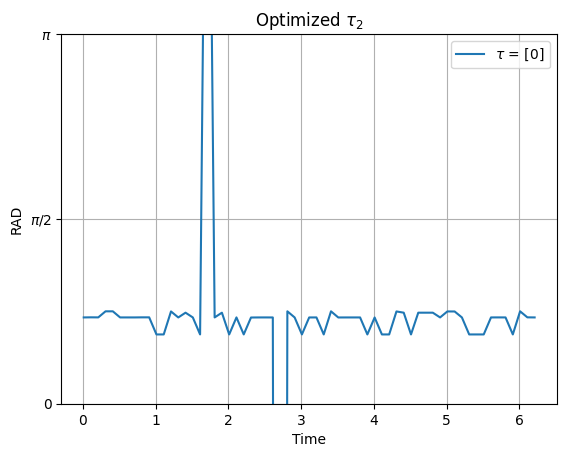

In [60]:
plt.plot(Data[:,0], Data[:,7], label = f'$\\tau$ = {tau_set}')
            
plt.yticks(
    [-np.pi, -np.pi/2, 0, np.pi/2, np.pi, (3*np.pi)/2, 2*np.pi], 
    ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']
)
plt.ylim(0, np.pi)
plt.title(f'Optimized $\\tau_{2}$')
plt.xlabel('Time')
plt.ylabel('RAD')
plt.grid()
plt.legend()
plt.show()